# K-Means Clustering Analysis for Books and Readers



This notebook focuses on **clustering analysis** for a library book recommendation system. The data has already been cleaned and preprocessed in a previous notebook, including:
- Handling duplicates and missing values
- Feature engineering
- Exploratory Data Analysis (EDA)

### Objectives
We will perform **two types of clustering**:

1. **Book Clustering** 
   - Group books based on borrowing patterns, popularity, and availability
   - Use case: Optimize acquisition decisions, recommendations, and storage

2. **Reader Clustering** 
   - Segment library users by reading behavior and engagement
   - Use case: Personalized recommendations and targeted outreach

### Methodology
- Elbow Method
- Silhouette Analysis
- PCA for dimensionality reduction

---

## 1. Import Libraries

In [58]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

os.makedirs('clustering_results', exist_ok=True)

## 2. Helper Functions

### Data Loading

In [59]:
def load_and_prepare_data(filepath, id_column):
    """Load data and separate features from ID"""
    df = pd.read_excel(filepath)
    ids = df[id_column].copy()
    features = df.drop(columns=[id_column])
    
    # Handle missing values
    features = features.fillna(features.mean())
    
    print(f"Dataset shape: {features.shape}")
    print(f"Features: {list(features.columns)}")
    print(f"\nMissing values: {features.isnull().sum().sum()}")
    
    return ids, features

### Scale the Data

In [60]:
def standardize_features(features):
    """Standardize features for clustering"""
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    return features_scaled, scaler

### Dimensionality Reduction (PCA)

In [61]:
def perform_pca_analysis(features_scaled, feature_names, title):
    """Perform PCA for dimensionality reduction and visualization"""
    print(f"\n{'='*60}")
    print(f"PCA ANALYSIS - {title}")
    print('='*60)
    
    pca_full = PCA()
    pca_full.fit(features_scaled)
    
    # Explained variance
    explained_var = pca_full.explained_variance_ratio_
    cumulative_var = np.cumsum(explained_var)
    
    print(f"\nExplained variance by component:")
    for i, (var, cum_var) in enumerate(zip(explained_var[:5], cumulative_var[:5])):
        print(f"PC{i+1}: {var:.4f} ({cum_var:.4f} cumulative)")
    
    # Determine number of components for 90% variance
    n_components_90 = np.argmax(cumulative_var >= 0.90) + 1
    print(f"\nComponents needed for 90% variance: {n_components_90}")
    
    # Apply PCA with optimal components
    pca = PCA(n_components=min(n_components_90, features_scaled.shape[1]))
    features_pca = pca.fit_transform(features_scaled)
    
    # Plot variance explained
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Scree plot
    axes[0].plot(range(1, len(explained_var)+1), explained_var, 'bo-')
    axes[0].set_xlabel('Principal Component')
    axes[0].set_ylabel('Explained Variance Ratio')
    axes[0].set_title(f'Scree Plot - {title}')
    axes[0].grid(True, alpha=0.3)
    
    # Cumulative variance
    axes[1].plot(range(1, len(cumulative_var)+1), cumulative_var, 'ro-')
    axes[1].axhline(y=0.90, color='g', linestyle='--', label='90% threshold')
    axes[1].set_xlabel('Number of Components')
    axes[1].set_ylabel('Cumulative Explained Variance')
    axes[1].set_title(f'Cumulative Variance - {title}')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Component loadings
    if features_pca.shape[1] >= 2:
        loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
        fig, ax = plt.subplots(figsize=(10, 8))
        
        for i, feature in enumerate(feature_names):
            ax.arrow(0, 0, loadings[i, 0], loadings[i, 1], 
                    head_width=0.05, head_length=0.05, fc='blue', ec='blue', alpha=0.6)
            ax.text(loadings[i, 0]*1.15, loadings[i, 1]*1.15, feature, 
                   fontsize=9, ha='center', va='center')
        
        ax.set_xlabel(f'PC1 ({explained_var[0]:.2%} variance)')
        ax.set_ylabel(f'PC2 ({explained_var[1]:.2%} variance)')
        ax.set_title(f'PCA Loading Plot - {title}')
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0, color='k', linewidth=0.5)
        ax.axvline(x=0, color='k', linewidth=0.5)
        
        plt.tight_layout()
        plt.show()
    
    return features_pca, pca, n_components_90

### Determining Optimal Number of Clusters
**Elbow Method**

In [62]:
def elbow_method(features, max_k=10, title=""):
    """Elbow method to determine optimal K for K-Means"""
    print(f"\n{'='*60}")
    print(f"ELBOW METHOD - {title}")
    print('='*60)
    
    sse = []
    silhouette_scores = []
    K_range = range(2, max_k+1)
    
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(features)
        sse.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(features, kmeans.labels_))
        print(f"K={k}: SSE={kmeans.inertia_:.2f}, Silhouette={silhouette_scores[-1]:.4f}")
    
    # Plot elbow curve
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # SSE plot
    axes[0].plot(K_range, sse, 'bo-', linewidth=2, markersize=8)
    axes[0].set_xlabel('Number of Clusters (K)')
    axes[0].set_ylabel('Sum of Squared Errors (SSE)')
    axes[0].set_title(f'Elbow Method - {title}')
    axes[0].grid(True, alpha=0.3)
    
    # Silhouette plot
    axes[1].plot(K_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
    axes[1].set_xlabel('Number of Clusters (K)')
    axes[1].set_ylabel('Silhouette Score')
    axes[1].set_title(f'Silhouette Scores - {title}')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Find optimal K (where silhouette is maximized)
    optimal_k = K_range[np.argmax(silhouette_scores)]
    print(f"\nOptimal K based on silhouette score: {optimal_k}")
    
    return optimal_k, sse, silhouette_scores

### Visualize clusters in PCA space

In [63]:
def visualize_clusters_2d(features, labels, title=""):
    """Visualize clusters in 2D using first 2 components"""
    fig, ax = plt.subplots(figsize=(10, 6))
    
    scatter = ax.scatter(features[:, 0], features[:, 1], 
                       c=labels, cmap='viridis', alpha=0.6, s=50)
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_title(f'K-Means Cluster Visualization - {title}')
    ax.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax, label='Cluster')
    
    plt.tight_layout()
    plt.show()

### Cluster Characteristics Analysis

In [64]:
def analyze_cluster_characteristics(features_original, labels, feature_names, title=""):
    """Analyze characteristics of each cluster"""
    print(f"\n{'='*60}")
    print(f"CLUSTER CHARACTERISTICS - {title}")
    print('='*60)
    
    df = pd.DataFrame(features_original, columns=feature_names)
    df['Cluster'] = labels
    
    cluster_stats = df.groupby('Cluster').agg(['mean', 'std', 'min', 'max'])
    
    print("\nCluster Statistics (Mean values):")
    print(df.groupby('Cluster').mean().to_string())
    
    return cluster_stats

## 3. Book Clustering Analysis

### 3.1 Load and Prepare Book Data

In [65]:
# Load book data
book_ids, book_features = load_and_prepare_data('processed_data/book_features.xlsx', 'titre')

Dataset shape: (133, 7)
Features: ['total_borrowings', 'avg_loan_duration', 'days_since_last_borrow', 'unique_readers', 'nbr_exemplaires', 'borrowing_rate', 'reader_diversity']

Missing values: 0


### 3.2 Standardize Features

In [66]:
# Standardize book features
book_features_scaled, book_scaler = standardize_features(book_features)

### 3.3 PCA Analysis


PCA ANALYSIS - Books

Explained variance by component:
PC1: 0.3646 (0.3646 cumulative)
PC2: 0.2528 (0.6175 cumulative)
PC3: 0.1639 (0.7814 cumulative)
PC4: 0.1398 (0.9212 cumulative)
PC5: 0.0788 (1.0000 cumulative)

Components needed for 90% variance: 4


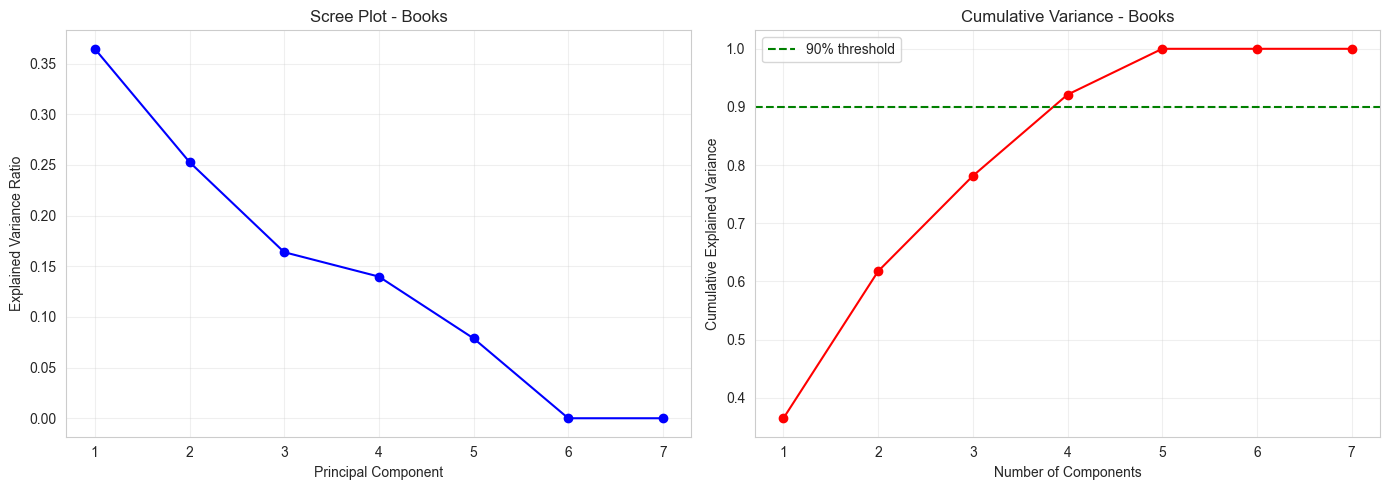

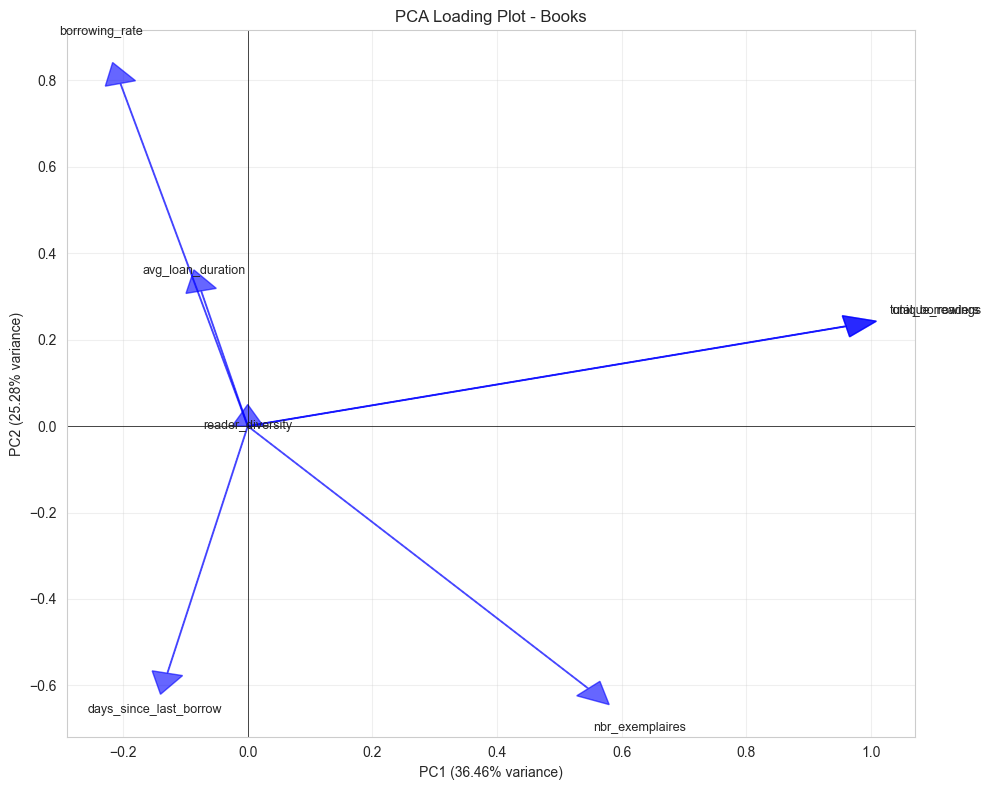

In [67]:
# Perform PCA
book_features_pca, book_pca, n_comp_books = perform_pca_analysis(
    book_features_scaled, 
    list(book_features.columns),
    "Books"
)

### 3.4 Elbow Method - Find Optimal K


ELBOW METHOD - Books
K=2: SSE=481.76, Silhouette=0.7832
K=3: SSE=348.49, Silhouette=0.5274
K=4: SSE=217.96, Silhouette=0.5675
K=5: SSE=127.46, Silhouette=0.5973
K=6: SSE=84.15, Silhouette=0.5318
K=7: SSE=69.60, Silhouette=0.5239
K=8: SSE=56.30, Silhouette=0.5042
K=9: SSE=50.14, Silhouette=0.5270
K=10: SSE=41.33, Silhouette=0.5274


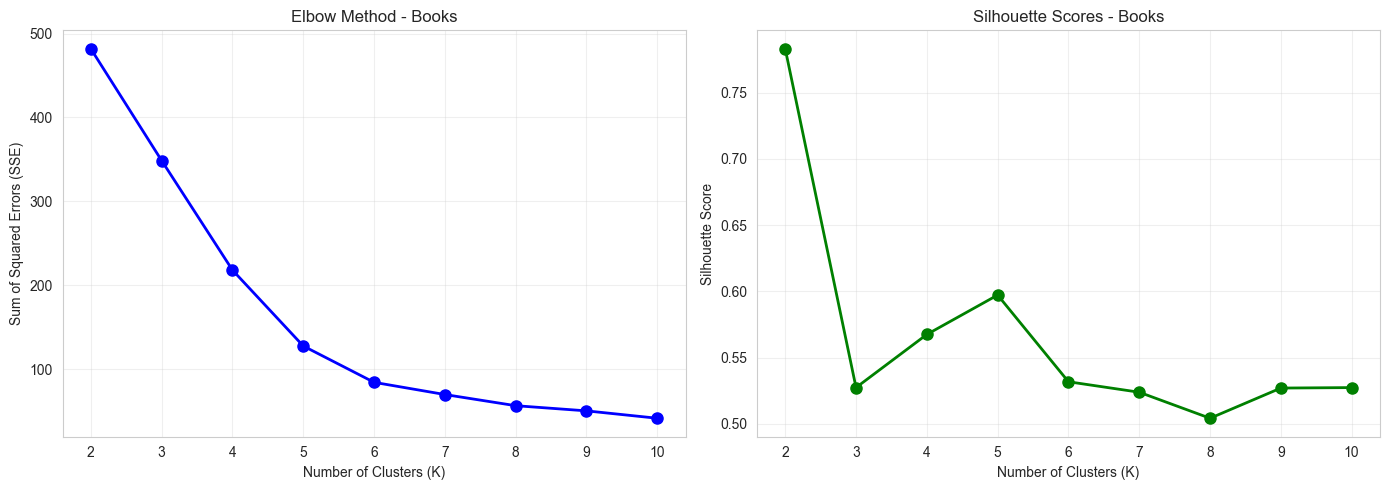


Optimal K based on silhouette score: 2


In [68]:
# Find optimal K using elbow method
optimal_k_books, sse_books, sil_books = elbow_method(
    book_features_pca, 
    max_k=10, 
    title="Books"
)

### 3.5 K-Means Clustering

In [69]:
print(f"\n{'='*60}")
print(f"K-MEANS CLUSTERING - Books")
print('='*60)

# Initialize and fit KMeans
kmeans_model_books = KMeans(n_clusters=optimal_k_books, random_state=42, n_init=10)
kmeans_labels_books = kmeans_model_books.fit_predict(book_features_pca)

print(f"\nClustering completed with {optimal_k_books} clusters")
print(f"Inertia (SSE): {kmeans_model_books.inertia_:.2f}")
print(f"Silhouette Score: {silhouette_score(book_features_pca, kmeans_labels_books):.4f}")

# Print cluster distribution
unique, counts = np.unique(kmeans_labels_books, return_counts=True)
print(f"\nCluster Distribution:")
for cluster_id, count in zip(unique, counts):
    print(f"  Cluster {cluster_id}: {count} samples ({count/len(kmeans_labels_books)*100:.1f}%)")


K-MEANS CLUSTERING - Books

Clustering completed with 2 clusters
Inertia (SSE): 481.76
Silhouette Score: 0.7832

Cluster Distribution:
  Cluster 0: 130 samples (97.7%)
  Cluster 1: 3 samples (2.3%)


### 3.6 Visualize Clusters

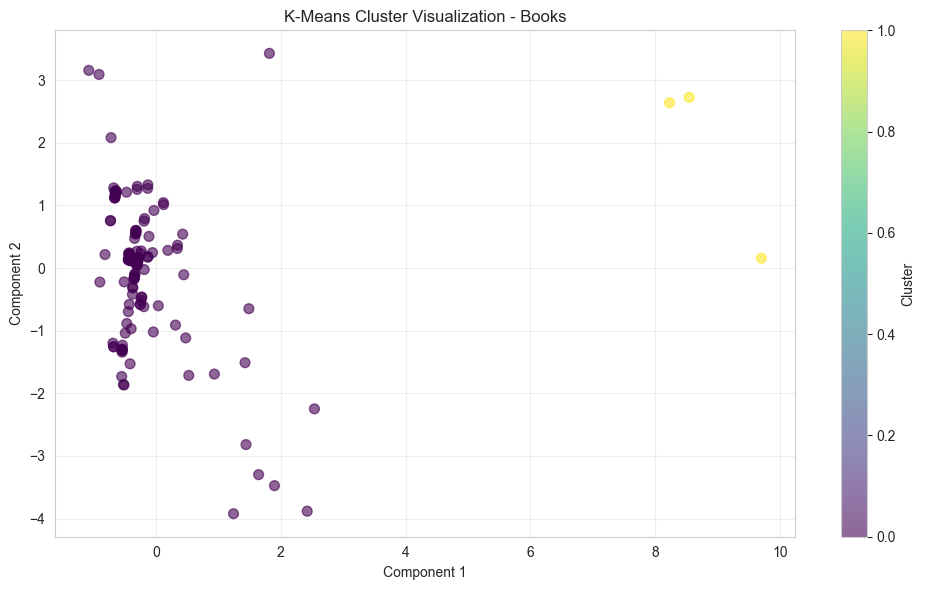

In [70]:
# Visualize book clusters
visualize_clusters_2d(book_features_pca, kmeans_labels_books, "Books")

### 3.6 📊 Book Clustering Evaluation Metrics

Comprehensive evaluation of book clustering quality using standard metrics.

In [71]:
# ============================================================
# BOOK CLUSTERING EVALUATION METRICS
# ============================================================

print("="*70)
print(" " * 15 + "BOOK CLUSTERING EVALUATION METRICS")
print("="*70)

# 1. Basic Clustering Information
n_clusters_books = len(np.unique(kmeans_labels_books))
print(f"\nCLUSTERING CONFIGURATION:")
print(f"   - Algorithm: K-Means (scikit-learn)")
print(f"   - Number of Clusters: {n_clusters_books}")
print(f"   - Total Books: {len(kmeans_labels_books)}")
print(f"   - Random State: 42")
print(f"   - Iterations: {kmeans_model_books.n_iter_}")

# 2. Cluster Distribution
print(f"\nCLUSTER DISTRIBUTION:")
print(f"   {'Cluster':<10} {'Count':<10} {'Percentage':<12} ")
print(f"   {'-'*60}")
unique, counts = np.unique(kmeans_labels_books, return_counts=True)
for cluster_id, count in zip(unique, counts):
    percentage = (count / len(kmeans_labels_books)) * 100
    bar = '#' * int(percentage / 2)
    print(f"   {cluster_id:<10} {count:<10} {percentage:>5.2f}%     ")

# 3. Overall Silhouette Score
silhouette_avg = silhouette_score(book_features_pca, kmeans_labels_books)
print(f"\nOVERALL SILHOUETTE SCORE: {silhouette_avg:.4f}")
print(f"   Interpretation: ", end="")
if silhouette_avg > 0.5:
    quality = "Excellent - Strong, well-separated clusters"
elif silhouette_avg > 0.3:
    quality = "Good - Reasonable cluster structure"
elif silhouette_avg > 0.2:
    quality = "Moderate - Weak but detectable structure"
else:
    quality = "Weak - No substantial structure"
print(quality)


               BOOK CLUSTERING EVALUATION METRICS

CLUSTERING CONFIGURATION:
   - Algorithm: K-Means (scikit-learn)
   - Number of Clusters: 2
   - Total Books: 133
   - Random State: 42
   - Iterations: 2

CLUSTER DISTRIBUTION:
   Cluster    Count      Percentage   
   ------------------------------------------------------------
   0          130        97.74%     
   1          3           2.26%     

OVERALL SILHOUETTE SCORE: 0.7832
   Interpretation: Excellent - Strong, well-separated clusters


### 3.7 Analyze Cluster Characteristics

In [72]:
# Analyze book cluster characteristics
book_cluster_stats = analyze_cluster_characteristics(
    book_features.values,
    kmeans_labels_books,
    list(book_features.columns),
    "Books"
)


CLUSTER CHARACTERISTICS - Books

Cluster Statistics (Mean values):
         total_borrowings  avg_loan_duration  days_since_last_borrow  unique_readers  nbr_exemplaires  borrowing_rate  reader_diversity
Cluster                                                                                                                                
0                1.969231          18.751245                    78.4        1.969231        14.300462        0.570684               1.0
1               55.333333          15.774346                     0.0       55.333333        56.840000        0.508086               1.0


### 3.8 Save Book Results

In [73]:
# Save book clustering results
book_results = pd.DataFrame({
    'Book': book_ids,
    'KMeans_Cluster': kmeans_labels_books
})

# Concatenate with original features
book_features_reset = book_features.reset_index(drop=True)
book_results = pd.concat([book_results, book_features_reset], axis=1)
book_results.to_excel('clustering_results/book_clustering_results.xlsx', index=False)
print("Book clustering results saved to: clustering_results/book_clustering_results.xlsx")

Book clustering results saved to: clustering_results/book_clustering_results.xlsx


## 4. Reader Clustering Analysis

### 4.1 Load and Prepare Reader Data

In [74]:
# Load reader data
reader_ids, reader_features = load_and_prepare_data('processed_data/reader_features.xlsx', 'n° lecteur')

Dataset shape: (271, 7)
Features: ['total_borrowings', 'avg_loan_duration', 'days_since_last_borrow', 'activity_span_days', 'unique_books', 'book_diversity', 'reading_frequency']

Missing values: 0


### 4.2 Standardize Features

In [75]:
# Standardize reader features
reader_features_scaled, reader_scaler = standardize_features(reader_features)

### 4.3 PCA Analysis


PCA ANALYSIS - Readers

Explained variance by component:
PC1: 0.4133 (0.4133 cumulative)
PC2: 0.2492 (0.6625 cumulative)
PC3: 0.1880 (0.8505 cumulative)
PC4: 0.1352 (0.9857 cumulative)
PC5: 0.0143 (1.0000 cumulative)

Components needed for 90% variance: 4


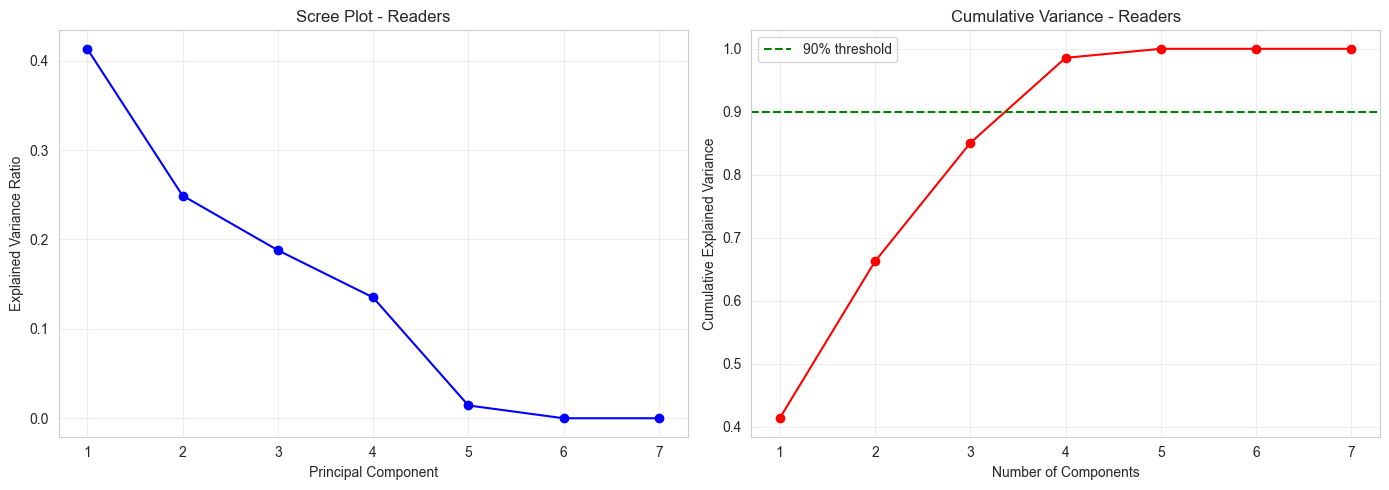

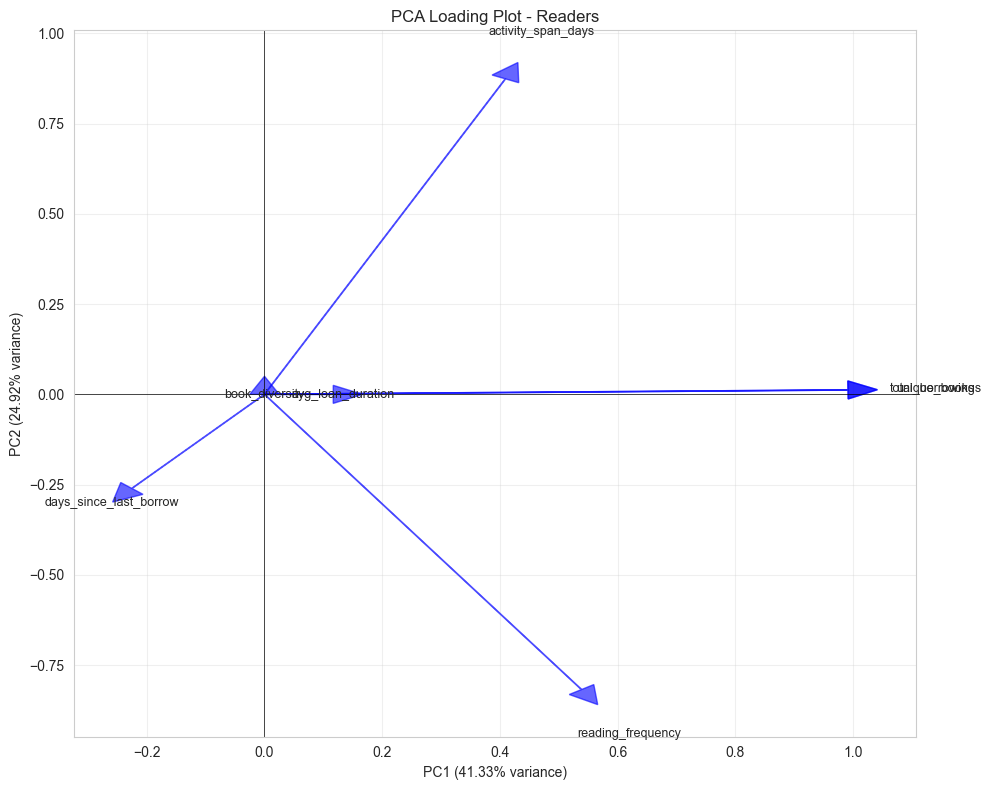

In [76]:
# Perform PCA
reader_features_pca, reader_pca, n_comp_readers = perform_pca_analysis(
    reader_features_scaled, 
    list(reader_features.columns),
    "Readers"
)

### 4.4 Elbow Method - Find Optimal K


ELBOW METHOD - Readers
K=2: SSE=1039.82, Silhouette=0.5199
K=3: SSE=679.20, Silhouette=0.6160
K=4: SSE=424.40, Silhouette=0.6257
K=5: SSE=239.63, Silhouette=0.7087
K=6: SSE=159.07, Silhouette=0.7551
K=7: SSE=97.67, Silhouette=0.8078
K=8: SSE=71.64, Silhouette=0.7990
K=9: SSE=53.37, Silhouette=0.8170
K=10: SSE=41.76, Silhouette=0.8096


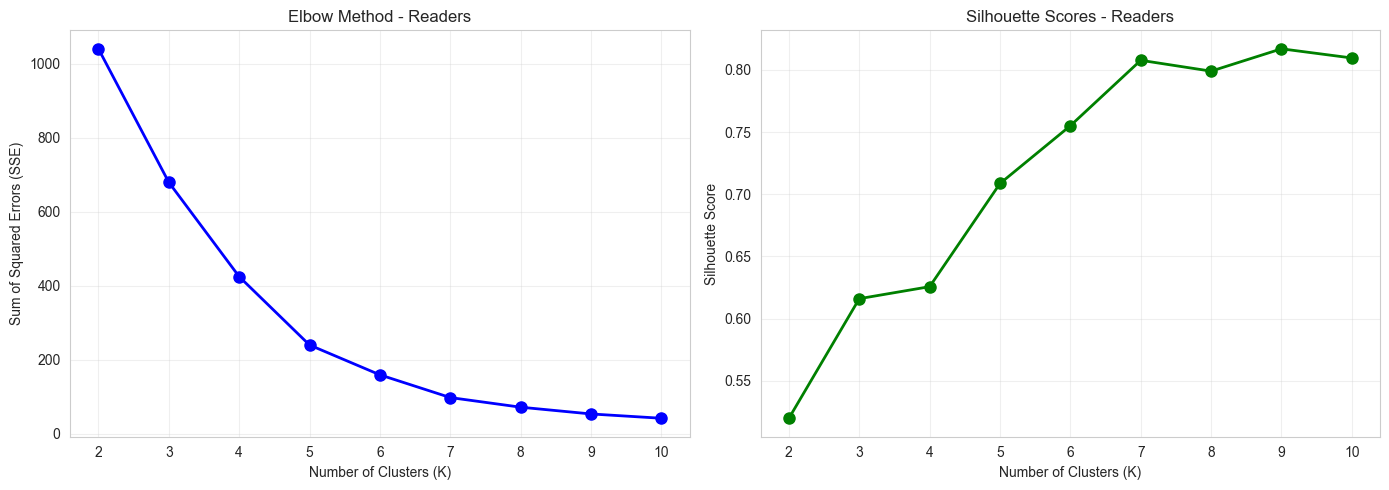


Optimal K based on silhouette score: 9


In [77]:
# Find optimal K using elbow method
optimal_k_readers, sse_readers, sil_readers = elbow_method(
    reader_features_pca, 
    max_k=10, 
    title="Readers"
)

### 4.5 K-Means Clustering

In [78]:
# Perform K-Means clustering for Readers using sklearn's predefined KMeans
print(f"\n{'='*60}")
print(f"K-MEANS CLUSTERING - Readers")
print('='*60)

# Initialize and fit KMeans
kmeans_model_readers = KMeans(n_clusters=optimal_k_readers, random_state=42, n_init=10)
kmeans_labels_readers = kmeans_model_readers.fit_predict(reader_features_pca)

print(f"\nClustering completed with {optimal_k_readers} clusters")
print(f"Inertia (SSE): {kmeans_model_readers.inertia_:.2f}")
print(f"Silhouette Score: {silhouette_score(reader_features_pca, kmeans_labels_readers):.4f}")

# Print cluster distribution
unique, counts = np.unique(kmeans_labels_readers, return_counts=True)
print(f"\nCluster Distribution:")
for cluster_id, count in zip(unique, counts):
    print(f"  Cluster {cluster_id}: {count} samples ({count/len(kmeans_labels_readers)*100:.1f}%)")


K-MEANS CLUSTERING - Readers

Clustering completed with 9 clusters
Inertia (SSE): 53.37
Silhouette Score: 0.8170

Cluster Distribution:
  Cluster 0: 34 samples (12.5%)
  Cluster 1: 61 samples (22.5%)
  Cluster 2: 13 samples (4.8%)
  Cluster 3: 118 samples (43.5%)
  Cluster 4: 1 samples (0.4%)
  Cluster 5: 16 samples (5.9%)
  Cluster 6: 14 samples (5.2%)
  Cluster 7: 8 samples (3.0%)
  Cluster 8: 6 samples (2.2%)


### 4.6 Visualize Clusters

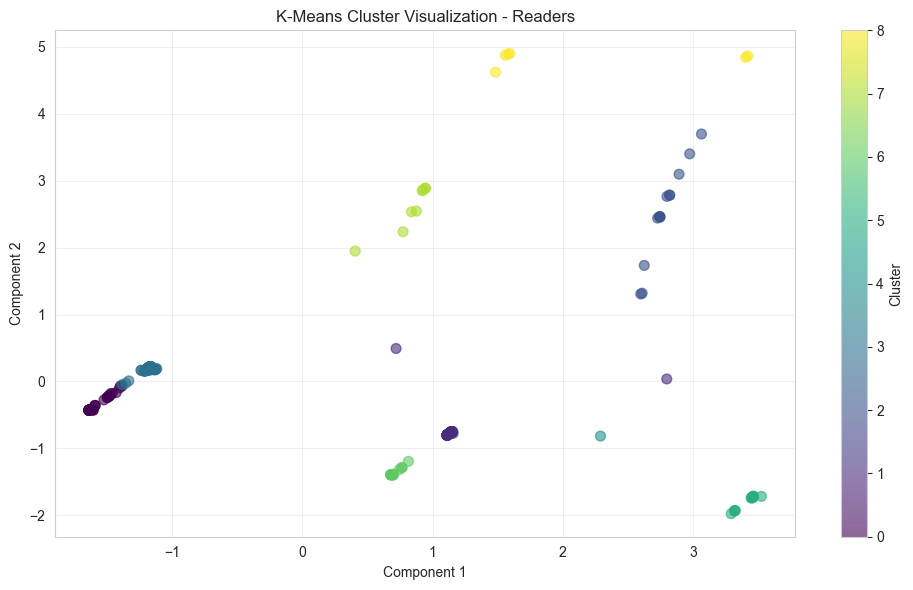

In [79]:
# Visualize reader clusters
visualize_clusters_2d(reader_features_pca, kmeans_labels_readers, "Readers")

### 4.6 📊 Reader Clustering Evaluation Metrics

Comprehensive evaluation of reader clustering quality using standard metrics.

In [80]:
# ============================================================
# READER CLUSTERING EVALUATION METRICS
# ============================================================

print("="*70)
print(" " * 15 + "READER CLUSTERING EVALUATION METRICS")
print("="*70)

# 1. Basic Clustering Information
n_clusters_readers = len(np.unique(kmeans_labels_readers))
print(f"\nCLUSTERING CONFIGURATION:")
print(f"   - Algorithm: K-Means (scikit-learn)")
print(f"   - Number of Clusters: {n_clusters_readers}")
print(f"   - Total Readers: {len(kmeans_labels_readers)}")
print(f"   - Random State: 42")
print(f"   - Iterations: {kmeans_model_readers.n_iter_}")

# 2. Cluster Distribution
print(f"\nCLUSTER DISTRIBUTION:")
print(f"   {'Cluster':<10} {'Count':<10} {'Percentage':<12} ")
print(f"   {'-'*60}")
unique, counts = np.unique(kmeans_labels_readers, return_counts=True)
for cluster_id, count in zip(unique, counts):
    percentage = (count / len(kmeans_labels_readers)) * 100
    bar = '#' * int(percentage / 2)
    print(f"   {cluster_id:<10} {count:<10} {percentage:>5.2f}% ")

# 3. Overall Silhouette Score
silhouette_avg = silhouette_score(reader_features_pca, kmeans_labels_readers)
print(f"\nOVERALL SILHOUETTE SCORE: {silhouette_avg:.4f}")
print(f"   Interpretation: ", end="")
if silhouette_avg > 0.5:
    quality = "Excellent - Strong, well-separated clusters"
elif silhouette_avg > 0.3:
    quality = "Good - Reasonable cluster structure"
elif silhouette_avg > 0.2:
    quality = "Moderate - Weak but detectable structure"
else:
    quality = "Weak - No substantial structure"
print(quality)

# 4. Per-Cluster Silhouette Scores
print(f"\nPER-CLUSTER SILHOUETTE SCORES:")
print(f"   {'Cluster':<10} {'Silhouette':<15} {'Quality'}")
print(f"   {'-'*50}")
silhouette_vals = silhouette_samples(reader_features_pca, kmeans_labels_readers)
for i in range(n_clusters_readers):
    cluster_silhouette = silhouette_vals[kmeans_labels_readers == i].mean()
    if cluster_silhouette > silhouette_avg:
        quality_mark = "Above Average"
    else:
        quality_mark = "Below Average"
    print(f"   {i:<10} {cluster_silhouette:<15.4f} {quality_mark}")



               READER CLUSTERING EVALUATION METRICS

CLUSTERING CONFIGURATION:
   - Algorithm: K-Means (scikit-learn)
   - Number of Clusters: 9
   - Total Readers: 271
   - Random State: 42
   - Iterations: 5

CLUSTER DISTRIBUTION:
   Cluster    Count      Percentage   
   ------------------------------------------------------------
   0          34         12.55% 
   1          61         22.51% 
   2          13          4.80% 
   3          118        43.54% 
   4          1           0.37% 
   5          16          5.90% 
   6          14          5.17% 
   7          8           2.95% 
   8          6           2.21% 

OVERALL SILHOUETTE SCORE: 0.8170
   Interpretation: Excellent - Strong, well-separated clusters

PER-CLUSTER SILHOUETTE SCORES:
   Cluster    Silhouette      Quality
   --------------------------------------------------
   0          0.6655          Below Average
   1          0.9053          Above Average
   2          0.5818          Below Average
   3          

### 4.7 Analyze Cluster Characteristics

In [81]:
# Analyze reader cluster characteristics
reader_cluster_stats = analyze_cluster_characteristics(
    reader_features.values,
    kmeans_labels_readers,
    list(reader_features.columns),
    "Readers"
)


CLUSTER CHARACTERISTICS - Readers

Cluster Statistics (Mean values):
         total_borrowings  avg_loan_duration  days_since_last_borrow  activity_span_days  unique_books  book_diversity  reading_frequency
Cluster                                                                                                                                  
0                1.000000           9.205882              317.176471            0.000000      1.000000             1.0           1.000000
1                2.016393          15.431694               17.327869            0.032787      2.016393             1.0           1.975410
2                3.000000          15.974359               10.230769            6.307692      3.000000             1.0           0.449642
3                1.000000          16.313559               18.389831            0.000000      1.000000             1.0           1.000000
4                2.000000         302.000000               39.000000            0.000000      2.000000

### 4.8 Save Reader Results

In [82]:
# Save reader clustering results
reader_results = pd.DataFrame({
    'Reader': reader_ids,
    'KMeans_Cluster': kmeans_labels_readers
})

# Concatenate with original features
reader_features_reset = reader_features.reset_index(drop=True)
reader_results = pd.concat([reader_results, reader_features_reset], axis=1)
reader_results.to_excel('clustering_results/reader_clustering_results.xlsx', index=False)
print("Reader clustering results saved to: clustering_results/reader_clustering_results.xlsx")

Reader clustering results saved to: clustering_results/reader_clustering_results.xlsx


## 5. Summary

This notebook has performed K-Means clustering analysis on both books and readers datasets. The analysis included:

1. **Data Preparation**: Loading and cleaning data
2. **Standardization**: Scaling features for clustering
3. **PCA**: Dimensionality reduction to capture 90% variance
4. **Elbow Method**: Finding optimal number of clusters
5. **K-Means Clustering**: Performing the clustering algorithm
6. **Evaluation**: Using silhouette analysis
7. **Visualization**: 2D cluster plots
8. **Results**: Saving clustered data to Excel files